In [140]:
import numpy as np
import pandas as pd
import xgboost as xgb
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [141]:
df = pd.read_csv('../udataset/hourly_earnings.csv')
meat_prod_df = pd.read_csv('../udataset/meat/production.csv')
# meat_cold_df = pd.read_csv('../udataset/meat/cold_storage.csv')
# meat_weights_df = pd.read_csv('../udataset/meat/weights.csv')
# meat_slaughter_df = pd.read_csv('../udataset/meat/slaughter.csv')


df = df.rename(columns={'YearMonth': 'date'})
meat_prod_df = meat_prod_df.rename(columns={'DateTime': 'date'})
# meat_cold_df = meat_cold_df.rename(columns={'DateTime': 'date'})
# meat_weights_df = meat_weights_df.rename(columns={'DateTime': 'date'})
# meat_slaughter_df = meat_slaughter_df.rename(columns={'DateTime': 'date'})



df['date'] = pd.to_datetime(df['date'])
meat_prod_df['date'] = pd.to_datetime(meat_prod_df['date'])
# meat_cold_df['date'] = pd.to_datetime(meat_cold_df['date'])
# meat_weights_df['date'] = pd.to_datetime(meat_weights_df['date'])
# meat_slaughter_df['date'] = pd.to_datetime(meat_slaughter_df['date'])

df = df.merge(meat_prod_df, on = ['date'], how='left')
# df = df.merge(meat_cold_df, on = ['date'], how='left')
# df = df.merge(meat_weights_df, on = ['date'], how='left')
# df = df.merge(meat_slaughter_df, on = ['date'], how='left')

for col in df.columns[2:]:
    df[col] = df[col].pct_change()

df = df.dropna()
# df = df.drop(columns=['State'])

model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
print(df.columns)


Index(['State', 'date', 'HourlyEarnings', 'Beef', 'Veal', 'Pork',
       'Lamb and Mutton', 'Broiler', 'Other Chicken', 'Turkey', 'Red Meat',
       'Poultry'],
      dtype='object')


/var/folders/_z/09vrqlq533g4mwf_3hh2dzrc0000gn/T/ipykernel_57330/4012204562.py:28: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[col] = df[col].pct_change()


In [150]:
train_df = df[df['date'].dt.year < 2021]
test_df = df[df['date'].dt.year >= 2021]

train_data = train_df.to_numpy()
train_labels = train_data[:, 2]

test_data = test_df.to_numpy()
test_labels = test_data[:, 2]


train_df = train_df.drop(columns=['date', 'HourlyEarnings'])
test_df = test_df.drop(columns=['date', 'HourlyEarnings'])

train_data = train_df.to_numpy()
test_data = test_df.to_numpy()

# train_data = np.delete(train_data, 1, axis=1)
# test_data = np.delete(test_data, 1, axis=1)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

         State      Beef      Veal      Pork  Lamb and Mutton   Broiler  \
1      alabama -0.097340 -0.150000 -0.138566        -0.041379 -0.119447   
2      alabama  0.085386  0.117647  0.137568         0.366906  0.097417   
3      alabama -0.048073 -0.127820 -0.080422        -0.247368 -0.014482   
4      alabama  0.135355  0.043103  0.030212         0.041958  0.099258   
5      alabama  0.028620 -0.090909 -0.061796        -0.120805 -0.045652   
...        ...       ...       ...       ...              ...       ...   
10463  wyoming -0.036276 -0.142857 -0.013357        -0.103774 -0.003177   
10464  wyoming  0.007528 -0.020833 -0.001848        -0.010526  0.038699   
10465  wyoming  0.050361  0.106383  0.113369        -0.021277 -0.007606   
10466  wyoming -0.082076 -0.096154 -0.073749         0.010870 -0.096339   
10467  wyoming  0.026654  0.170213  0.043505         0.150538  0.069607   

       Other Chicken    Turkey  Red Meat   Poultry  
1          -0.081013  0.124213 -0.116529 -0.08

In [143]:
le = LabelEncoder()
le.fit(train_data[:, 0])
train_data[:, 0] = le.transform(train_data[:, 0])
train_data.shape

(8567, 10)

In [144]:
# define model evaluation method
# evaluate model
# scores = cross_val_score(model, train_data, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
model.fit(train_data, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [145]:
test_data[:, 0] = le.transform(test_data[:, 0])
test_data.shape

(1938, 10)

In [146]:
#scores = absolute(scores)
#print(scores)
#print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
preds = model.predict(test_data)

In [147]:
preds

array([ 8.3661620e-03,  8.0767255e-03, -5.4735830e-04, ...,
        9.7003700e-05,  2.4808901e-03,  2.4808901e-03], dtype=float32)

In [148]:
(absolute(test_labels - preds)).mean()


0.00826055032987712

1938


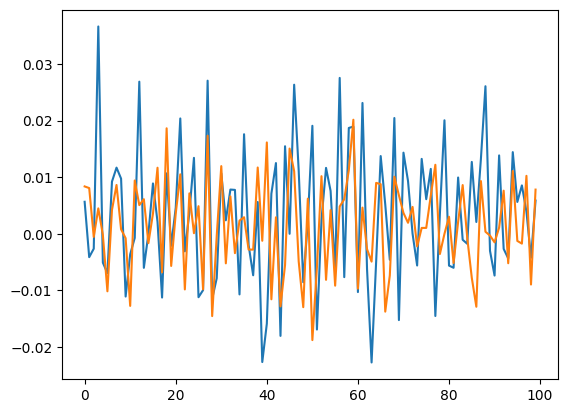

In [149]:
print(len(preds))
x = np.array(range(len(preds)))[:100]
y1 = test_labels[:100]
y2 = preds[:100]
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()